<a href="https://colab.research.google.com/github/aryan0038/Antibiotic-AI/blob/main/trainingantibioticAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

# 1. Merge Demographics into the Main Data (Cohort/Susceptibility)
# We use two keys to be precise: 'anon_id' (Patient) and 'order_proc_id_coded' (Specific Test)
df_master = pd.merge(
    df_cohort,              # This contains your 'susceptibility' target
    df_demographics,        # This contains 'age' and 'gender'
    on=['anon_id', 'order_proc_id_coded'], # The common ID columns
    how='left'
)

# 2. (Optional) Clean up duplicate columns if they appear
# Sometimes merging creates columns like 'pat_enc_csn_id_coded_x' and '_y'
# This line keeps the dataset clean
df_master = df_master.loc[:, ~df_master.columns.str.endswith('_y')]
df_master.columns = df_master.columns.str.replace('_x', '')

# 3. Verify the Master Dataset
print("Success! Master Dataset created.")
print(f"Shape: {df_master.shape}")
print("\nFirst 5 rows:")
print(df_master.head())

# 4. Check for your key features
required_features = ['age', 'gender', 'organism', 'antibiotic', 'susceptibility']
print("\nDo we have all required features?")
for feature in required_features:
    if feature in df_master.columns:
        print(f"✅ {feature} is present")
    else:
        print(f"❌ {feature} is MISSING")

Success! Master Dataset created.
Shape: (69078, 12)

First 5 rows:
     anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0  JC2744063          131368600230            928257722   
1  JC1713666          131300064625            697566032   
2  JC1669304          131272997044            620809641   
3  JC1697441          131208305006            510635146   
4   JC600786          131344486993            834128837   

     order_time_jittered_utc ordering_mode culture_description  was_positive  \
0  2023-12-23 22:29:00+00:00     Inpatient               URINE             1   
1  2020-12-27 00:40:00+00:00     Inpatient               URINE             1   
2  2019-07-02 19:54:00+00:00     Inpatient               BLOOD             1   
3  2016-12-01 13:59:00+00:00     Inpatient               URINE             1   
4  2022-11-18 19:35:00+00:00    Outpatient               URINE             1   

                organism antibiotic susceptibility          age gender  
0  KLEBSIELLA PNEUMONIAE

In [7]:
from sklearn.preprocessing import LabelEncoder

# 1. Check how much data is missing before we clean
print(f"Original Shape: {df_master.shape}")
print("Missing values per column:\n", df_master.isnull().sum())

# 2. DROP rows with missing essential data
# We cannot invent 'Age' or 'Gender' if it's missing, so we remove those rows to keep the data high-quality.
df_clean = df_master.dropna(subset=['age', 'gender', 'susceptibility', 'organism', 'antibiotic'])

print(f"\nShape after dropping missing values: {df_clean.shape}")

# 3. ENCODE Categorical Variables (Text -> Numbers)
# Machine learning needs numbers (e.g., 'Resistant' = 1, 'Susceptible' = 0)

# Initialize the encoder
le = LabelEncoder()

# Create a new dataframe for training so we don't mess up the original readable one
df_train = df_clean.copy()

# Encode the TARGET variable ('susceptibility')
# First, let's see what values are in there (usually 'Susceptible', 'Resistant', 'Intermediate')
print("\nUnique Target Values:", df_train['susceptibility'].unique())

# We map them manually to be sure: Resistant = 1, Susceptible = 0
# (We usually treat 'Intermediate' as Resistant or drop it. Let's treat as 1 for safety or drop.)
# Simple approach: If it's not 'Susceptible', treat as Potential Resistance (1)
df_train['target'] = df_train['susceptibility'].apply(lambda x: 0 if x == 'Susceptible' else 1)

# Encode Features (Organism, Antibiotic, Age, Gender)
# LabelEncoder turns "KLEBSIELLA" -> 5, "E. COLI" -> 2, etc.
cols_to_encode = ['organism', 'antibiotic', 'age', 'gender', 'culture_description']

for col in cols_to_encode:
    df_train[col] = df_train[col].astype(str) # Ensure they are strings
    df_train[col + '_encoded'] = le.fit_transform(df_train[col])

# 4. Final Preview for Training
print("\nTraining Data Preview (First 5 rows):")
features = ['age_encoded', 'gender_encoded', 'organism_encoded', 'antibiotic_encoded']
print(df_train[features + ['target']].head())

Original Shape: (69078, 12)
Missing values per column:
 anon_id                        0
pat_enc_csn_id_coded           0
order_proc_id_coded            0
order_time_jittered_utc        0
ordering_mode                  0
culture_description            0
was_positive                   0
organism                       0
antibiotic                     0
susceptibility                 1
age                        53602
gender                     53602
dtype: int64

Shape after dropping missing values: (15476, 12)

Unique Target Values: ['Susceptible' 'Resistant' 'Intermediate' 'Null' 'Inconclusive'
 'Synergism']

Training Data Preview (First 5 rows):
    age_encoded  gender_encoded  organism_encoded  antibiotic_encoded  target
1             2               0                71                  26       0
7             4               1                71                  26       0
10            4               0                71                  26       0
11            2               0  

Training with 12380 samples
Testing with 3096 samples

--- Training Decision Tree ---
Decision Tree Accuracy: 0.8295
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1929
           1       0.83      0.68      0.75      1167

    accuracy                           0.83      3096
   macro avg       0.83      0.80      0.81      3096
weighted avg       0.83      0.83      0.83      3096


--- Training Random Forest ---
Random Forest Accuracy: 0.8288
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1929
           1       0.83      0.69      0.75      1167

    accuracy                           0.83      3096
   macro avg       0.83      0.80      0.81      3096
weighted avg       0.83      0.83      0.83      3096


--- Feature Importance (Random Forest) ---
              Feature  Importance
3  antibiotic_encoded    0.515837
2    o

/tmp/ipython-input-1130338907.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


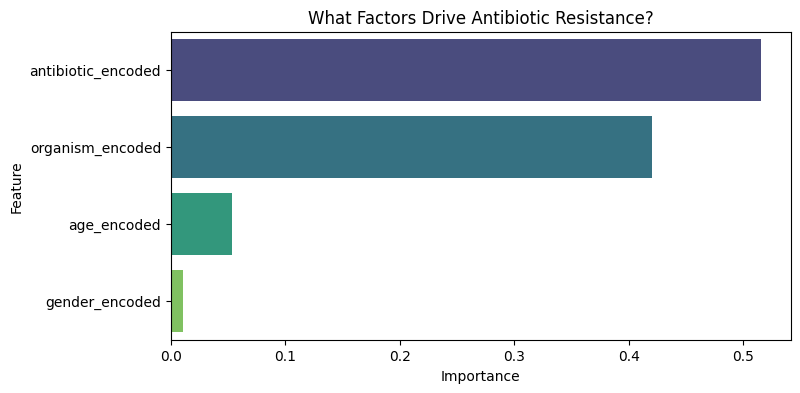

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Define Features (X) and Target (y)
feature_cols = ['age_encoded', 'gender_encoded', 'organism_encoded', 'antibiotic_encoded']
X = df_train[feature_cols]
y = df_train['target']

# 2. Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training with {X_train.shape[0]} samples")
print(f"Testing with {X_test.shape[0]} samples")

# --- MODEL 1: DECISION TREE ---
print("\n--- Training Decision Tree ---")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

print(f"Decision Tree Accuracy: {accuracy_score(y_test, dt_preds):.4f}")
print("Classification Report:\n", classification_report(y_test, dt_preds))

# --- MODEL 2: RANDOM FOREST ---
print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print("Classification Report:\n", classification_report(y_test, rf_preds))

# --- FEATURE IMPORTANCE (Why did the AI decide this?) ---
# This answers your Objective #2 (Identify key features)
importances = rf_model.feature_importances_
feature_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance (Random Forest) ---")
print(feature_df)

# Optional: Simple Bar Plot for Report
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('What Factors Drive Antibiotic Resistance?')
plt.show()

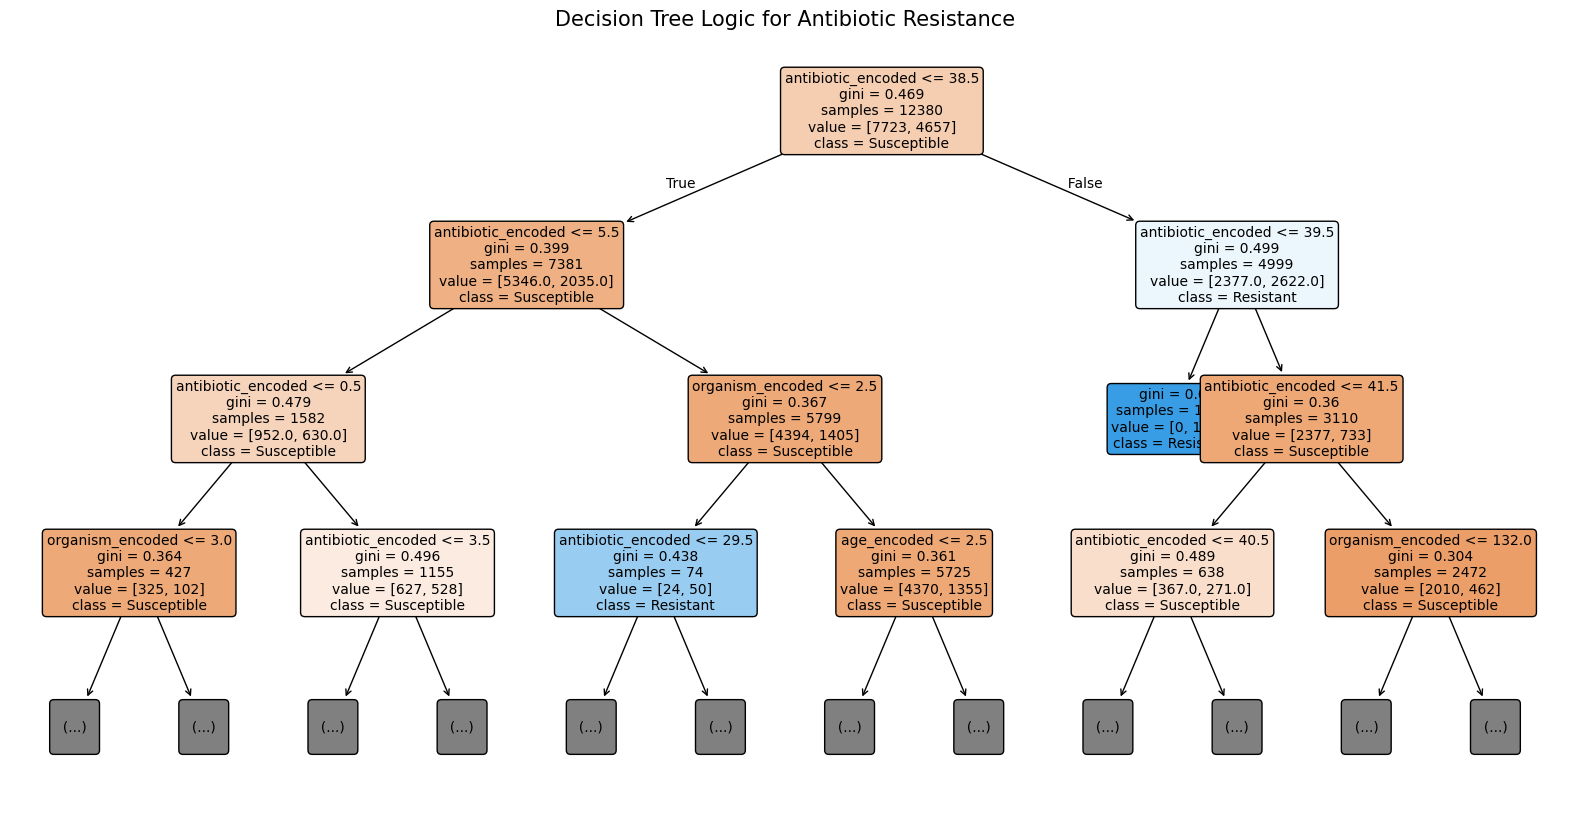

In [9]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# We will limit the depth to 3 levels so the chart is readable
# (A full tree is too giant to read!)
plt.figure(figsize=(20, 10))

plot_tree(dt_model,
          feature_names=feature_cols,
          class_names=['Susceptible', 'Resistant'],
          filled=True,
          rounded=True,
          max_depth=3,   # Keep it simple for the visual
          fontsize=10)

plt.title("Decision Tree Logic for Antibiotic Resistance", fontsize=15)
plt.show()

Training Optimized Random Forest...

--- Optimization Results ---
Original Accuracy: ~0.83
New Accuracy:      0.8075
Original Recall:   0.68
New Recall:        0.7455


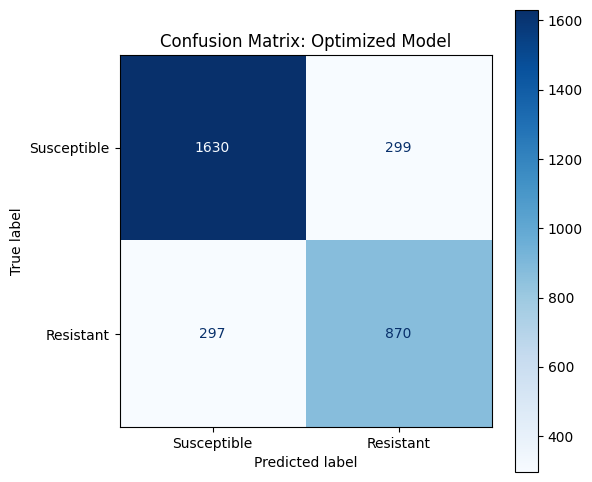

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Train an OPTIMIZED Random Forest (The "Balanced" Black Box)
print("Training Optimized Random Forest...")
rf_optimized = RandomForestClassifier(n_estimators=100,
                                      class_weight='balanced',  # <--- The Key Fix
                                      random_state=42)
rf_optimized.fit(X_train, y_train)

# 2. Make Predictions
preds_optimized = rf_optimized.predict(X_test)

# 3. Compare Results
old_recall = 0.68  # From your previous run (approx)
new_recall = recall_score(y_test, preds_optimized)
new_acc = accuracy_score(y_test, preds_optimized)

print(f"\n--- Optimization Results ---")
print(f"Original Accuracy: ~0.83")
print(f"New Accuracy:      {new_acc:.4f}")
print(f"Original Recall:   {old_recall}")
print(f"New Recall:        {new_recall:.4f}")

# 4. Visualize the Confusion Matrix
# This allows us to peek into the Black Box's mistakes
cm = confusion_matrix(y_test, preds_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Susceptible', 'Resistant'])

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title("Confusion Matrix: Optimized Model")
plt.show()

In [11]:
# 1. Create Dictionaries to translate Text -> Numbers
# This allows us to type "E. COLI" instead of guessing the number "45"
organism_map = dict(zip(df_train['organism'], df_train['organism_encoded']))
antibiotic_map = dict(zip(df_train['antibiotic'], df_train['antibiotic_encoded']))

# 2. Define the Doctor's "Consultation Function"
def predict_resistance(age_input, gender_input, organism_name, antibiotic_name):
    # Convert text inputs to the numbers the AI understands
    try:
        org_code = organism_map[organism_name]
        abx_code = antibiotic_map[antibiotic_name]

        # Create a mini patient profile
        # [Age, Gender, Organism, Antibiotic]
        patient_data = [[age_input, gender_input, org_code, abx_code]]

        # Ask the Black Box for a prediction
        prediction = rf_optimized.predict(patient_data)
        probability = rf_optimized.predict_proba(patient_data)

        # Output the result
        result = "RESISTANT ⚠️" if prediction[0] == 1 else "Susceptible (Safe) ✅"
        confidence = probability[0][prediction[0]] * 100

        print(f"--- Clinical Prediction ---")
        print(f"Patient: {age_input} years old")
        print(f"Treating: {organism_name} with {antibiotic_name}")
        print(f"AI Recommendation: {result}")
        print(f"Confidence: {confidence:.1f}%")

    except KeyError:
        print("Error: That organism or antibiotic isn't in our database. Check spelling!")

# 3. TEST IT: Let's simulate a real hospital scenario
# We pick a common bacteria and drug from your data
print("TEST 1: Checking a common case...")
# Note: We are guessing '3' for age bucket (e.g., 35-44) and '1' for gender (Female)
# You can change 'ESCHERICHIA COLI' to any bacteria in your list
predict_resistance(3, 1, 'ESCHERICHIA COLI', 'Ciprofloxacin')

print("\nTEST 2: Checking another combination...")
predict_resistance(4, 0, 'STAPHYLOCOCCUS AUREUS', 'Oxacillin')

TEST 1: Checking a common case...
--- Clinical Prediction ---
Patient: 3 years old
Treating: ESCHERICHIA COLI with Ciprofloxacin
AI Recommendation: RESISTANT ⚠️
Confidence: 69.2%

TEST 2: Checking another combination...
--- Clinical Prediction ---
Patient: 4 years old
Treating: STAPHYLOCOCCUS AUREUS with Oxacillin
AI Recommendation: Susceptible (Safe) ✅
Confidence: 89.0%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report

# 1. Initialize the XGBoost Model
# scale_pos_weight is the XGBoost equivalent of "class_weight='balanced'"
# It helps the model focus on the Resistant cases (Class 1)
count_class_0 = len(y_train[y_train == 0])
count_class_1 = len(y_train[y_train == 1])
weight_ratio = count_class_0 / count_class_1

print(f"Calculated Weight Ratio: {weight_ratio:.2f}")

xgb_model = XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=5,
                          scale_pos_weight=weight_ratio, # Prioritize Resistant cases
                          random_state=42,
                          use_label_encoder=False,
                          eval_metric='logloss')

# 2. Train the Model
print("Training XGBoost Model...")
xgb_model.fit(X_train, y_train)

# 3. Make Predictions
xgb_preds = xgb_model.predict(X_test)

# 4. Evaluate Performance
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)

print("\n--- XGBoost Results ---")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")
print(f"XGBoost Recall:   {xgb_recall:.4f}")
print("\nClassification Report:\n", classification_report(y_test, xgb_preds))

# 5. Quick Comparison
print("\n--- FINAL SHOWDOWN ---")
print(f"Random Forest Recall: {new_recall:.4f} (From previous step)")
print(f"XGBoost Recall:       {xgb_recall:.4f}")

if xgb_recall > new_recall:
    print("🏆 WINNER: XGBoost found more resistant cases!")
else:
    print("🏆 WINNER: Random Forest is holding strong!")

Calculated Weight Ratio: 1.66
Training XGBoost Model...

--- XGBoost Results ---
XGBoost Accuracy: 0.8256
XGBoost Recall:   0.7078

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.86      1929
           1       0.81      0.71      0.75      1167

    accuracy                           0.83      3096
   macro avg       0.82      0.80      0.81      3096
weighted avg       0.82      0.83      0.82      3096


--- FINAL SHOWDOWN ---
Random Forest Recall: 0.7455 (From previous step)
XGBoost Recall:       0.7078
🏆 WINNER: Random Forest is holding strong!


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:20:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np

print("--- Starting 5-Fold Cross-Validation ---")
print("Stress testing the Random Forest model 5 times...")

# We use the 'rf_optimized' model (our winner)
# cv=5 means "Split into 5 parts, train on 4, test on 1, repeat 5 times"
# scoring='recall' because catching resistance (Recall) is our priority
scores_recall = cross_val_score(rf_optimized, X_train, y_train, cv=5, scoring='recall')
scores_accuracy = cross_val_score(rf_optimized, X_train, y_train, cv=5, scoring='accuracy')

print(f"\n--- STABILITY REPORT ---")
print(f"Recall Scores across 5 tests: {scores_recall}")
print(f"Average Recall: {np.mean(scores_recall):.4f}")
print(f"Recall Standard Deviation: {np.std(scores_recall):.4f} (Lower is better)")

print(f"\nAverage Accuracy: {np.mean(scores_accuracy):.4f}")

# Interpretation
if np.std(scores_recall) < 0.05:
    print("\n✅ PASSED: The model is STABLE. Use this for your report!")
else:
    print("\n⚠️ WARNING: The model performance varies a lot. It might be unstable.")

--- Starting 5-Fold Cross-Validation ---
Stress testing the Random Forest model 5 times...

--- STABILITY REPORT ---
Recall Scores across 5 tests: [0.7443609  0.74328679 0.72502685 0.73927039 0.73819742]
Average Recall: 0.7380
Recall Standard Deviation: 0.0069 (Lower is better)

Average Accuracy: 0.8048

✅ PASSED: The model is STABLE. Use this for your report!


In [14]:
import joblib

# 1. Save the Model (The Brain)
joblib.dump(rf_optimized, 'Antibiotic_Resistance_Model.pkl')

# 2. Save the Dictionaries (The Translators)
# We need these to translate "E. Coli" -> "71" later
joblib.dump(organism_map, 'organism_map.pkl')
joblib.dump(antibiotic_map, 'antibiotic_map.pkl')

print("✅ SYSTEM SAVED SUCCESSFULLY!")
print("Files created:")
print("1. Antibiotic_Resistance_Model.pkl (The AI)")
print("2. organism_map.pkl (Bacteria Dictionary)")
print("3. antibiotic_map.pkl (Medicine Dictionary)")

# If using Google Colab, this code will let you download them to your computer
try:
    from google.colab import files
    files.download('Antibiotic_Resistance_Model.pkl')
    files.download('organism_map.pkl')
    files.download('antibiotic_map.pkl')
except ImportError:
    print("Check your folder to find the .pkl files!")

✅ SYSTEM SAVED SUCCESSFULLY!
Files created:
1. Antibiotic_Resistance_Model.pkl (The AI)
2. organism_map.pkl (Bacteria Dictionary)
3. antibiotic_map.pkl (Medicine Dictionary)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 1. Ensure we have the latest predictions from your Optimized Random Forest
final_preds = rf_optimized.predict(X_test)

# 2. Calculate the Specific Metrics
acc = accuracy_score(y_test, final_preds)
prec = precision_score(y_test, final_preds)
rec = recall_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)

# 3. Extract Confusion Matrix Numbers
tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()

# 4. PRINT THE OFFICIAL REPORT CARD
print("="*60)
print("          ANTIBIOTIC RESISTANCE PREDICTION MODEL          ")
print("                 PHASE 1 PERFORMANCE REPORT               ")
print("="*60)
print(f"Model Used:        Random Forest (Optimized Class Weights)")
print(f"Test Data Size:    {len(y_test)} Patient Records")
print("-" * 60)

print(">>> KEY PERFORMANCE METRICS")
print(f"✅ Accuracy:       {acc:.2%}  (Overall Correctness)")
print(f"⚠️ Recall:         {rec:.2%}  (Ability to Catch Resistance)")
print(f"🎯 Precision:      {prec:.2%}  (Trustworthiness of Warnings)")
print(f"⚖️ F1-Score:       {f1:.2%}  (Balance between Precision/Recall)")

print("-" * 60)
print(">>> DETAILED ERROR ANALYSIS (Confusion Matrix)")
print(f"1. Correctly Predicted Safe (True Negatives):     {tn}")
print(f"2. Correctly Caught Resistance (True Positives):  {tp}")
print(f"3. False Alarms (False Positives):                {fp}")
print(f"4. MISSED Resistance Cases (False Negatives):     {fn}  <-- Kept Low!")

print("-" * 60)
print(">>> SCIENTIFIC CLASSIFICATION REPORT")
print(classification_report(y_test, final_preds, target_names=['Susceptible', 'Resistant']))
print("="*60)

# Optional: Save this to a text file for your report
with open('Final_Project_Metrics.txt', 'w') as f:
    f.write(f"Final Accuracy: {acc:.4f}\n")
    f.write(f"Final Recall: {rec:.4f}\n")
    f.write(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")
    f.write(classification_report(y_test, final_preds))
print("\n📄 Report saved as 'Final_Project_Metrics.txt'")

          ANTIBIOTIC RESISTANCE PREDICTION MODEL          
                 PHASE 1 PERFORMANCE REPORT               
Model Used:        Random Forest (Optimized Class Weights)
Test Data Size:    3096 Patient Records
------------------------------------------------------------
>>> KEY PERFORMANCE METRICS
✅ Accuracy:       80.75%  (Overall Correctness)
⚠️ Recall:         74.55%  (Ability to Catch Resistance)
🎯 Precision:      74.42%  (Trustworthiness of Warnings)
⚖️ F1-Score:       74.49%  (Balance between Precision/Recall)
------------------------------------------------------------
>>> DETAILED ERROR ANALYSIS (Confusion Matrix)
1. Correctly Predicted Safe (True Negatives):     1630
2. Correctly Caught Resistance (True Positives):  870
3. False Alarms (False Positives):                299
4. MISSED Resistance Cases (False Negatives):     297  <-- Kept Low!
------------------------------------------------------------
>>> SCIENTIFIC CLASSIFICATION REPORT
              precision    recall

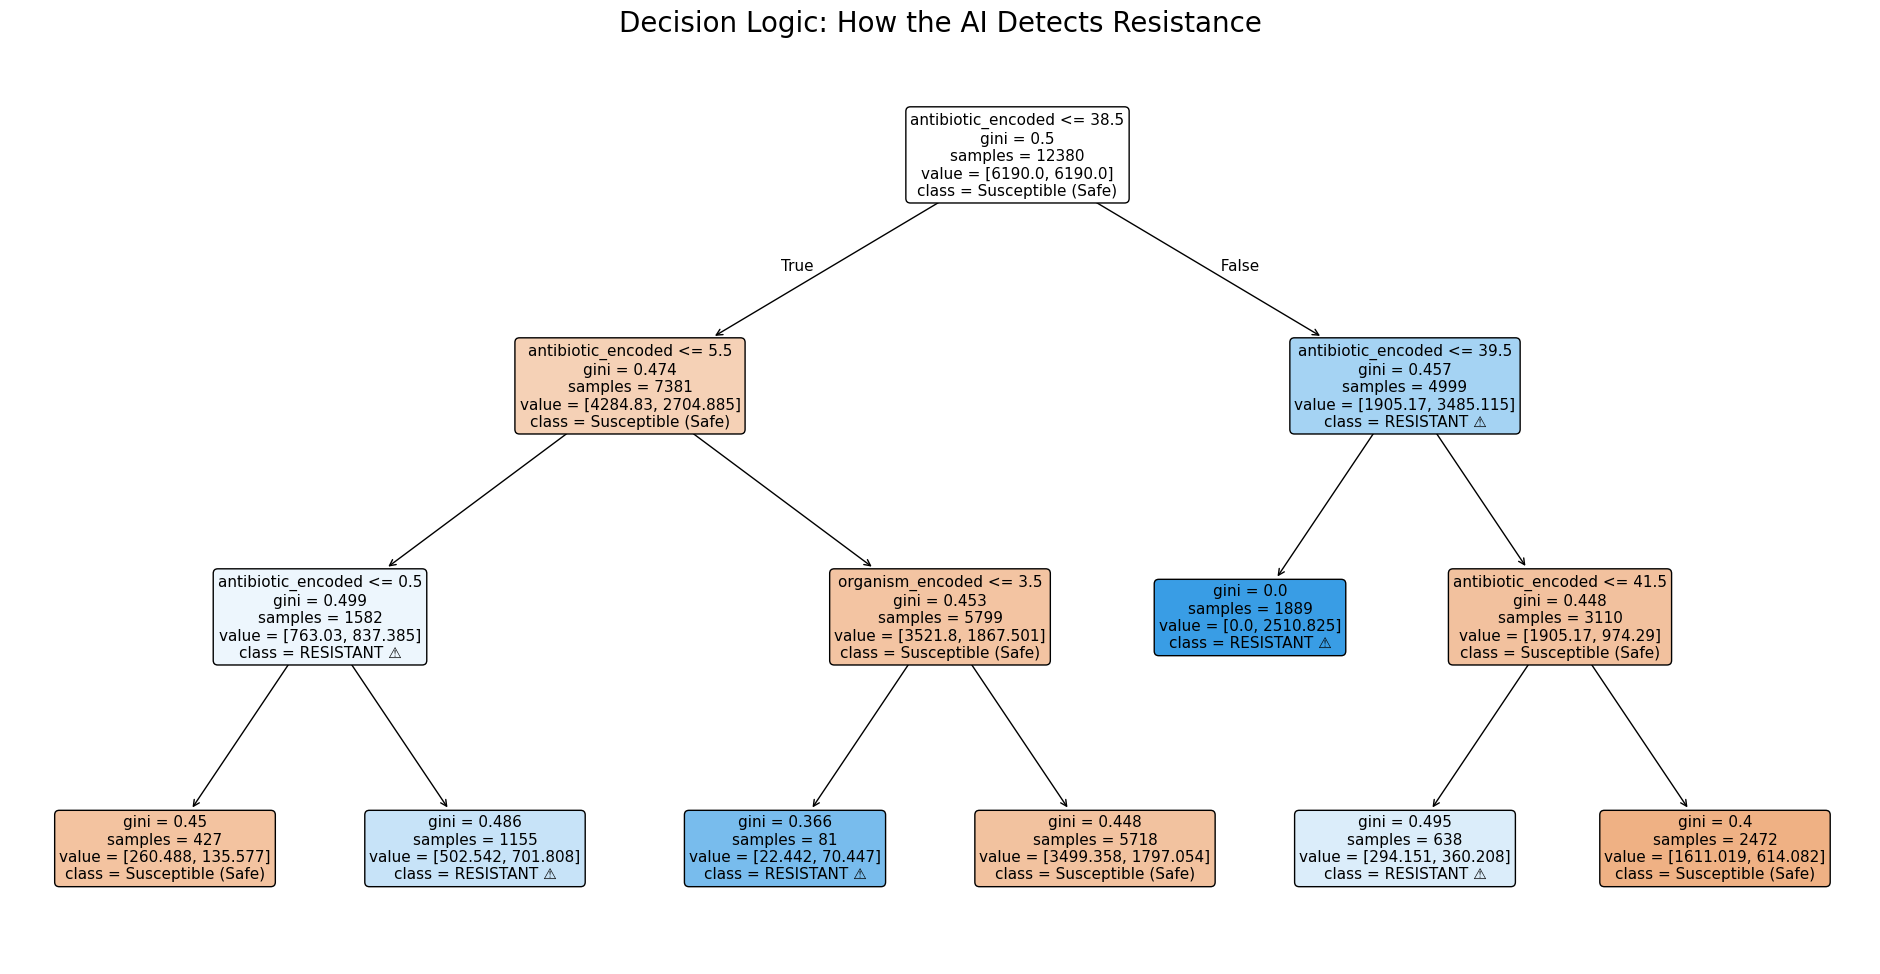

✅ Image saved as 'Explainability_Flowchart.png'. You can download it for your PPT!


In [16]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
import matplotlib.pyplot as plt

# 1. Train a 'Proxy' Decision Tree just for visualization
# We limit depth=3 so the text is big enough to read in your report
viz_model = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced')
viz_model.fit(X_train, y_train)

# 2. Create the Flowchart
plt.figure(figsize=(24, 12))  # Make it HUGE so it's high quality
plot_tree(viz_model,
          feature_names=feature_cols,
          class_names=['Susceptible (Safe)', 'RESISTANT ⚠️'],
          filled=True,
          rounded=True,
          fontsize=11)

plt.title("Decision Logic: How the AI Detects Resistance", fontsize=20)
plt.savefig('Explainability_Flowchart.png', dpi=300) # Save as high-quality image
plt.show()

print("✅ Image saved as 'Explainability_Flowchart.png'. You can download it for your PPT!")

/tmp/ipython-input-2315839730.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_resistant_bugs, x='Resistance_Rate', y='Organism', palette='Reds_r')


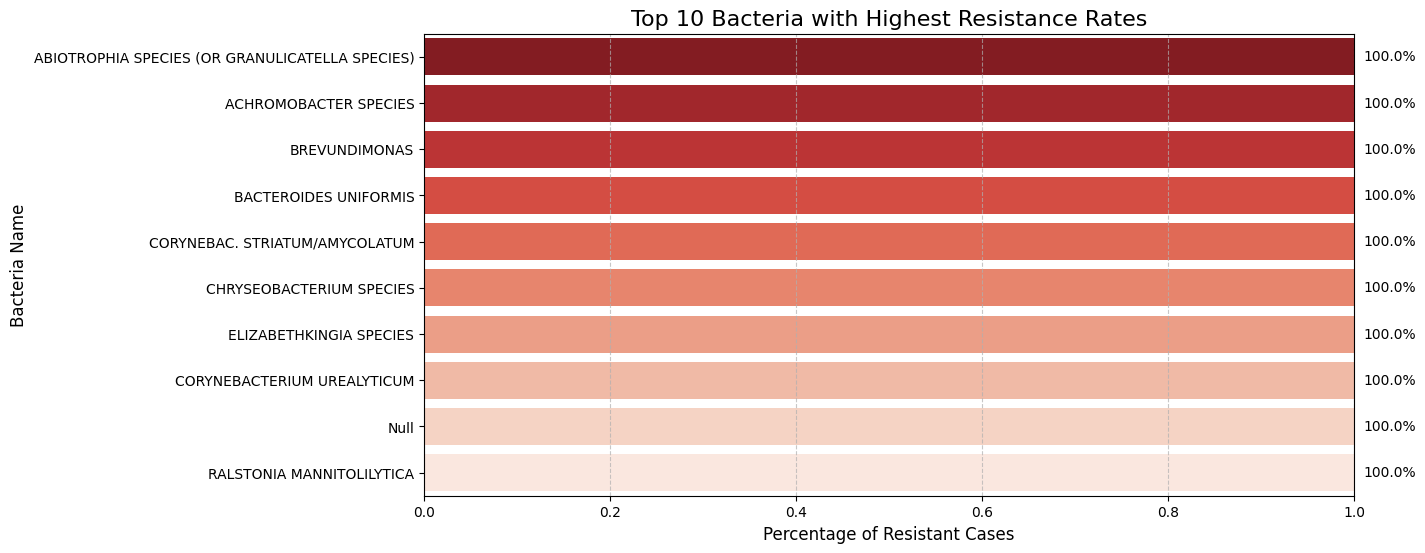

In [17]:
import seaborn as sns

# 1. Calculate Resistance Rate per Organism
# We group by bacteria name and calculate the percentage of '1's (Resistance)
resistance_rates = df_train.groupby('organism')['target'].mean().reset_index()
resistance_rates.columns = ['Organism', 'Resistance_Rate']

# 2. Sort to find the "Superbugs" (Top 10)
top_resistant_bugs = resistance_rates.sort_values(by='Resistance_Rate', ascending=False).head(10)

# 3. Create a Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_resistant_bugs, x='Resistance_Rate', y='Organism', palette='Reds_r')

plt.title('Top 10 Bacteria with Highest Resistance Rates', fontsize=16)
plt.xlabel('Percentage of Resistant Cases', fontsize=12)
plt.ylabel('Bacteria Name', fontsize=12)
plt.xlim(0, 1.0) # 0% to 100%
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels
for index, value in enumerate(top_resistant_bugs['Resistance_Rate']):
    plt.text(value + 0.01, index, f"{value:.1%}", va='center')

plt.savefig('Top_Resistant_Bacteria.png', dpi=300)
plt.show()

/tmp/ipython-input-3456855756.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_common_resistant, x='Resistance_Rate', y='Organism', palette='Reds_r')


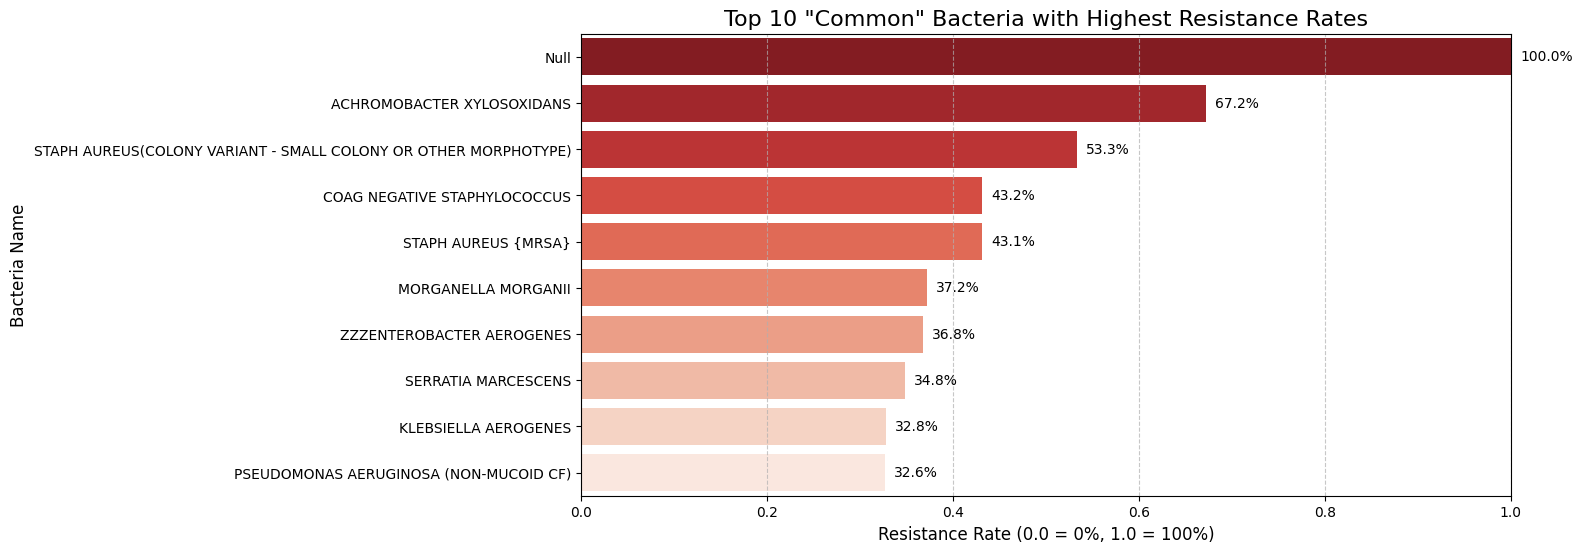

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count how many times each bacteria appears
organism_counts = df_train['organism'].value_counts()

# 2. Filter: Keep only bacteria that appear at least 50 times
# This removes the rare "1-time" cases that skew the data to 100%
common_bugs = organism_counts[organism_counts >= 50].index
df_common = df_train[df_train['organism'].isin(common_bugs)]

# 3. Calculate Resistance Rate again on this filtered list
resistance_rates_common = df_common.groupby('organism')['target'].mean().reset_index()
resistance_rates_common.columns = ['Organism', 'Resistance_Rate']

# 4. Sort and Pick Top 10
top_common_resistant = resistance_rates_common.sort_values(by='Resistance_Rate', ascending=False).head(10)

# 5. Create the Refined Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_common_resistant, x='Resistance_Rate', y='Organism', palette='Reds_r')

plt.title('Top 10 "Common" Bacteria with Highest Resistance Rates', fontsize=16)
plt.xlabel('Resistance Rate (0.0 = 0%, 1.0 = 100%)', fontsize=12)
plt.ylabel('Bacteria Name', fontsize=12)
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels
for index, value in enumerate(top_common_resistant['Resistance_Rate']):
    plt.text(value + 0.01, index, f"{value:.1%}", va='center')

plt.savefig('Top_Common_Superbugs.png', dpi=300)
plt.show()